In [1]:
# define libraries to use
import pandas as pd
import numpy as np
from pathlib import Path
import requests,json
import matplotlib.pyplot as plt
import math

# variables that need initialization

# dict of dataframes

# CRRS
crssDf = {}
# NY state vehicle registrations
#nydmvDf = None

# Main Table
farsMainTbl = "accident"
farsKey = "CASENUM"
crssMainTbl = "accident"
crssKey = "CASENUM"

def bulkreadcsv2df(myFolder, printProgress = False, lowMemory = True):
    """read each csv file in a folder into a df, each df added to as a separate dictionary entry with index a filename"""
    p = Path(myFolder)
    resDct = {}
    fileList = list(p.glob("*.CSV")) + list(p.glob("*.csv"))
    # sort file list based on stem of filename in lowercase
    fileList = sorted(fileList,key=lambda ppath: str(ppath.stem).lower())
    for myFile in fileList:
        dfName = myFile.stem.lower()
        if printProgress:
            print("Reading ",dfName)
        resDct[dfName] = pd.read_csv(str(myFile),encoding = 'unicode_escape', low_memory=lowMemory)

    return resDct



In [2]:
#crssDf = bulkreadcsv2df("data/FARS2020NationalCSV/", lowMemory= False)
crssDf = bulkreadcsv2df("data/CRSS2020CSV/", lowMemory= False)
#crssDf = bulkreadcsv2df("data/CRSS2016CSV/", lowMemory= False)
#nydmvDf = pd.read_csv("data/nydmv/nydmv.csv",encoding = "unicode_escape", low_memory=False)

#print("FARS Tables = ",list(crssDf.keys()))
print("CRSS Tables = ",list(crssDf.keys()))

CRSS Tables =  ['accident', 'cevent', 'crashrf', 'damage', 'distract', 'drimpair', 'driverrf', 'factor', 'maneuver', 'nmcrash', 'nmdistract', 'nmimpair', 'nmprior', 'parkwork', 'pbtype', 'person', 'personrf', 'pvehiclesf', 'safetyeq', 'vehicle', 'vehiclesf', 'vevent', 'violatn', 'vision', 'vpicdecode', 'vpictrailerdecode', 'vsoe', 'weather']


In [3]:
print("                               C    R    S    S                                                           ")
for idx in crssDf.keys():
    print("==========================================================================================================")
    print("=                                                                                                        =")
    print("=",idx)
    crssDf[idx].info(verbose=True,show_counts=True)
    print("=                                                                                                        =")
    print("==========================================================================================================")


                               C    R    S    S                                                           
=                                                                                                        =
= accident
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54745 entries, 0 to 54744
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CASENUM         54745 non-null  int64  
 1   STRATUM         54745 non-null  int64  
 2   STRATUMNAME     54745 non-null  object 
 3   REGION          54745 non-null  int64  
 4   REGIONNAME      54745 non-null  object 
 5   PSU             54745 non-null  int64  
 6   PJ              54745 non-null  int64  
 7   PSU_VAR         54745 non-null  int64  
 8   URBANICITY      54745 non-null  int64  
 9   URBANICITYNAME  54745 non-null  object 
 10  VE_TOTAL        54745 non-null  int64  
 11  VE_FORMS        54745 non-null  int64  
 12  PVH_INVL        54745 non-null 

# CRSS Table Cleanup to reduce to columns of interest and remove redundant data

## Create Categorical variables based on data

Pandas categorical data type not used so as to keep the original category codes

In [4]:
# crssCategories will hold the categorical mappings for categorical colums

crssCategories = {}

crssCategoricalColumns = {
    "accident" : [
        ["STRATUM","STRATUMNAME"],
        ["REGION","REGIONNAME"],
        ["MONTH","MONTHNAME"],
        ["DAY_WEEK","DAY_WEEKNAME"],
        ["URBANICITY","URBANICITYNAME"],
        ["HARM_EV","HARM_EVNAME"],
        ["MAN_COLL","MAN_COLLNAME"],
        ["ALCOHOL","ALCOHOLNAME"],
        ["MAX_SEV","MAX_SEVNAME"],
        ["LGT_COND","LGT_CONDNAME"],
        ["WEATHER","WEATHERNAME"],
        ["LGTCON_IM","LGTCON_IMNAME"],
        ["WEATHR_IM","WEATHR_IMNAME"],
        ["MAXSEV_IM","MAXSEV_IMNAME"],
        ["ALCHL_IM","ALCHL_IMNAME"],
    ],
    "vehicle" : [
        ["NUMOCCS","NUMOCCSNAME"],
        ["MAKE","MAKENAME"],
        ["MAK_MOD","MAK_MODNAME"],
        ["BODY_TYP","BODY_TYPNAME"],
        ["BDYTYP_IM","BDYTYP_IMNAME"],
        ["TOW_VEH","TOW_VEHNAME"],
        ["TRAV_SP","TRAV_SPNAME"],
        ["ROLLOVER","ROLLOVERNAME"],
        ["M_HARM","M_HARMNAME"],
        ["DR_PRES","DR_PRESNAME"],
        #["L_STATUS","L_STATUSNAME"],
        #["L_TYPE","L_TYPENAME"],
        #["PREV_ACC","PREV_ACCNAME"],
        #["PREV_DWI","PREV_DWINAME"],
        #["PREV_SPD","PREV_SPDNAME"],
        #["PREV_OTH","PREV_OTHNAME"],
        ["SPEEDREL","SPEEDRELNAME"],
        ["VSURCOND","VSURCONDNAME"],
        ["P_CRASH2","P_CRASH2NAME"],
        ["ACC_TYPE","ACC_TYPENAME"],
        ["VEH_ALCH","VEH_ALCHNAME"],
        ["V_ALCH_IM","V_ALCH_IMNAME"],
        ["VPICMAKE","VPICMAKENAME"],
        ["VPICMODEL","VPICMODELNAME"],
        ["VPICBODYCLASS","VPICBODYCLASSNAME"],
    ],
    "person" : [
        ["SEX","SEXNAME"],
        ["SEX_IM","SEX_IMNAME"],
        ["PER_TYP","PER_TYPNAME"],
        ["INJ_SEV","INJ_SEVNAME"],
        ["INJSEV_IM","INJSEV_IMNAME"],
        ["SEAT_POS","SEAT_POSNAME"],
        ["REST_USE","REST_USENAME"],
        ["AIR_BAG","AIR_BAGNAME"],
        ["EJECTION","EJECTIONNAME"],
        ["EJECT_IM","EJECT_IMNAME"],
        ["LOCATION","LOCATIONNAME"],
        ["DRINKING","DRINKINGNAME"],
        ["PERALCH_IM","PERALCH_IMNAME"],
    ],
    "parkwork" : [
		["PNUMOCCS","PNUMOCCSNAME"],
		["PTYPE","PTYPENAME"],
		["PMAKE","PMAKENAME"],
		["PMAK_MOD","PBODYTYP"],
		["PTRAILER","PTRAILERNAME"],
		["PM_HARM","PM_HARMNAME"],
    ],
    "pbtype" : [
        ["PBPTYPE","PBPTYPENAME"],
        ["PBAGE","PBAGENAME"],
        ["PBSEX","PBSEXNAME"],
    ],
    "vevent" : [
        ["AOI1","AOI1NAME"],
        ["AOI2","AOI2NAME"],
    ],
    "crashrf" : [
        ["CRASHRF","CRASHRFNAME"],
    ],
    "driverrf" : [
        ["DRIVERRF","DRIVERRFNAME"],
    ],
    "distract" : [
        ["DRDISTRACT","DRDISTRACTNAME"],
    ],
    "drimpair" : [
        ["DRIMPAIR", "DRIMPAIRNAME"],
    ],
    "factor" : [
        ["VEHICLECC","VEHICLECCNAME"],
    ],
    "vision" : [
        ["VISION", "VISIONNAME"],
    ],
    "nmcrash" : [
        ["NMCC","NMCCNAME"],
    ],
    "vpicdecode" : [
        ["VehicleTypeId","VehicleType"],
		["ManufacturerFullNameId","ManufacturerFullName"],
		["MakeId","Make"],
		["ModelId","Model"],
		["BodyClassId","BodyClass"],
        ["GrossVehicleWeightRatingFromId","GrossVehicleWeightRatingFrom"],
        ["GrossVehicleWeightRatingToId","GrossVehicleWeightRatingTo"],
        # safety features
		["ForwardCollisionWarningId","ForwardCollisionWarning"],
		["DynamicBrakeSupportId","DynamicBrakeSupport"],
		["CrashImminentBrakingID","CrashImminentBraking"],
		["PedestrianAutoEmergencyBrakingId","PedestrianAutoEmergencyBraking"],
		["BlindSpotWarningId","BlindSpotWarning"],
		["BlindSpotInterventionId","BlindSpotIntervention"],
		["LaneDepartureWarningId","LaneDepartureWarning"],
		["LaneKeepingAssistanceId","LaneKeepingAssistance"],
		["LaneCenteringAssistanceId","LaneCenteringAssistance"],
		["BackupCameraId","BackupCamera"],
		["RearCrossTrafficAlertId","RearCrossTrafficAlert"],
		["RearAutomaticEmergencyBrakingId","RearAutomaticEmergencyBraking"],
		["ParkAssistId","ParkAssist"],
		["DaytimeRunningLightId","DaytimeRunningLight"],
		["HeadlampLightSourceId","HeadlampLightSource"],
		["SemiAutoHeadlampBeamSwitchingId","SemiAutoHeadlampBeamSwitching"],
		["AdaptiveDrivingBeamId","AdaptiveDrivingBeam"],
		["AdaptiveCruiseControlId","AdaptiveCruiseControl"],
		["AntilockBrakeSystemId","AntilockBrakeSystem"],
		["ElectronicStabilityControlId","ElectronicStabilityControl"],
		["TPMSId","TPMS"],
		["TractionControlId","TractionControl"],
		["AutoPedestrianAlertingSoundId","AutoPedestrianAlertingSound"],
    ]
}

for dataFile in crssCategoricalColumns.keys():
    print(dataFile, "======================================")
    for catCol in crssCategoricalColumns[dataFile]:
        print(catCol, end=",")
        crssCategories[catCol[0]] = dict(np.array(crssDf[dataFile][catCol].drop_duplicates()))
    print()



accident ======================================
['STRATUM', 'STRATUMNAME'],['REGION', 'REGIONNAME'],['MONTH', 'MONTHNAME'],['DAY_WEEK', 'DAY_WEEKNAME'],['URBANICITY', 'URBANICITYNAME'],['HARM_EV', 'HARM_EVNAME'],['MAN_COLL', 'MAN_COLLNAME'],['ALCOHOL', 'ALCOHOLNAME'],['MAX_SEV', 'MAX_SEVNAME'],['LGT_COND', 'LGT_CONDNAME'],['WEATHER', 'WEATHERNAME'],['LGTCON_IM', 'LGTCON_IMNAME'],['WEATHR_IM', 'WEATHR_IMNAME'],['MAXSEV_IM', 'MAXSEV_IMNAME'],['ALCHL_IM', 'ALCHL_IMNAME'],
vehicle ======================================
['NUMOCCS', 'NUMOCCSNAME'],['MAKE', 'MAKENAME'],['MAK_MOD', 'MAK_MODNAME'],['BODY_TYP', 'BODY_TYPNAME'],['BDYTYP_IM', 'BDYTYP_IMNAME'],['TOW_VEH', 'TOW_VEHNAME'],['TRAV_SP', 'TRAV_SPNAME'],['ROLLOVER', 'ROLLOVERNAME'],['M_HARM', 'M_HARMNAME'],['DR_PRES', 'DR_PRESNAME'],['SPEEDREL', 'SPEEDRELNAME'],['VSURCOND', 'VSURCONDNAME'],['P_CRASH2', 'P_CRASH2NAME'],['ACC_TYPE', 'ACC_TYPENAME'],['VEH_ALCH', 'VEH_ALCHNAME'],['V_ALCH_IM', 'V_ALCH_IMNAME'],['VPICMAKE', 'VPICMAKENAME'],['VP

In [5]:
# FARS non-categorical Columns

crssNumericalColumns = {
    "accident" : [
		"CASENUM",
		"PSU",
		"PJ",
		"PSU_VAR",
		"VE_TOTAL",
		"VE_FORMS",
		"PVH_INVL",
		"PEDS",
		#"PERSONS",
		"PERMVIT",
		"PERNOTMVIT",
		#"DAY",
		"YEAR",
		"HOUR",
		"MINUTE",
		#"FATALS",
		"NUM_INJ",
		"NO_INJ_IM",
		"WEIGHT",
    ],
    "vehicle" : [
		"CASENUM",
		"VEH_NO",
		"MOD_YEAR",
		"MDLYR_IM",
		"VIN",
		#"DEATHS",
		"WEIGHT",
    ],
    "person" : [
		"CASENUM",
		"VEH_NO",
		"PER_NO",
		"STR_VEH",
		"AGE",
		"AGE_IM",
		"WEIGHT",
    ],
    "parkwork" : [
		"CASENUM",
		"VEH_NO",
		"PBODYTYPNAME",
		"PMODYEAR",
		"PVIN",
		#"PDEATHS",
		"WEIGHT",
    ],
    "pbtype" : [
		"CASENUM",
		"VEH_NO",
		"PER_NO",
		"WEIGHT",
    ],
    "vevent" : [
		"CASENUM",
		"VEH_NO",
		#"VEVENTNUM",
		"VNumber1",
		"VNumber2",
		"VNumber2NAME",
		"WEIGHT",
    ],
    "crashrf" : [
		"CASENUM",
		"WEIGHT",
    ],
    "driverrf" : [
		"CASENUM",
		"VEH_NO",
		"WEIGHT",
    ],
    "distract" : [
		"CASENUM",
		"VEH_NO",
		"WEIGHT",
    ],
    "drimpair" : [
		"CASENUM",
		"VEH_NO",
		"WEIGHT",
    ],
    "factor" : [
		"CASENUM",
		"VEH_NO",
		"WEIGHT",
    ],
    "vision" : [
		"CASENUM",
		"VEH_NO",
		"WEIGHT",
    ],
    "nmcrash" : [
		"CASENUM",
		"VEH_NO",
		"PER_NO",
		"WEIGHT",
    ],
	"vpicdecode" : [
		"CASENUM",
		"VEH_NO",
		"VehicleDescriptor",
		"VINDecodeError",
		"ModelYear",
		"Series",
		"Trim",
		"Series2",
		"Trim2",
		"CurbWeightLB",
	]
} 

# Drop all columns except chosen ones
for dataFile in crssNumericalColumns.keys():
	print(dataFile, "======================================")
	# all columns
	columnSet = set(crssDf[dataFile].columns)
	for catCol in crssCategoricalColumns[dataFile]:
		# remove categorical index column so that it is preserved (not dropped)
		columnSet.remove(catCol[0])
	for catCol in crssNumericalColumns[dataFile]:
		# remove numerical column we want to preserve (not dropped)
		columnSet.remove(catCol)
	# remove unwanted columns
	crssDf[dataFile].drop(columns = columnSet,inplace = True)
	print(crssDf[dataFile].columns) 

accident ======================================
Index(['CASENUM', 'STRATUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY',
       'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERMVIT', 'PERNOTMVIT',
       'NUM_INJ', 'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV',
       'ALCOHOL', 'MAX_SEV', 'MAN_COLL', 'LGT_COND', 'WEATHER', 'LGTCON_IM',
       'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM', 'WEIGHT'],
      dtype='object')
vehicle ======================================
Index(['CASENUM', 'VEH_NO', 'NUMOCCS', 'MAKE', 'MAK_MOD', 'BODY_TYP',
       'MOD_YEAR', 'VIN', 'TOW_VEH', 'TRAV_SP', 'ROLLOVER', 'M_HARM',
       'VEH_ALCH', 'DR_PRES', 'SPEEDREL', 'VSURCOND', 'P_CRASH2', 'ACC_TYPE',
       'VPICMAKE', 'VPICMODEL', 'VPICBODYCLASS', 'BDYTYP_IM', 'MDLYR_IM',
       'V_ALCH_IM', 'WEIGHT'],
      dtype='object')
person ======================================
Index(['CASENUM', 'VEH_NO', 'PER_NO', 'STR_VEH', 'AGE', 'SEX', 'PER_TYP',
       'INJ_SEV', 'SEAT_POS', 'REST_USE', '

In [6]:
#pd.DataFrame(crssCategories["HARM_EV"],columns=["id","name"]).to_csv("HARM_EV.csv")

# add simplified HARM_EV category HARM_EV_SIMP, and simplified PHARM_EV_SIMP
crssCategories["HARM_EV_SIMP"] = dict(
    [
        [1,"Animal"],
	    [2,"Building"],
	    [3,"Fixed object"],
	    [4,"Jackknife"],
	    [5,"Motor Vehicle In-Transport"],
	    [6,"Non-Collision"],
	    [7,"Non-Motorist on Personal Conveyance"],
	    [8,"Object not-fixed"],
	    [9,"Parked Motor Vehicle"],
	    [10,"Road Surface"],
	    [11,"Pedalcyclist"],
	    [12,"Pedestrian"],
	    [13,"Railway Vehicle"],
	    [14,"Rollover/Overturn"],
	    [15,"Snow Bank"],
	    [16,"Traffic Barrier"],
	    [17,"Working Motor Vehicle"],
	    [99,"Unknown"]
    ]
)
#crssCategories["PHARM_EV_SIMP"] = crssCategories["HARM_EV_SIMP"].copy()

# HARM_EV mapping to HARM_EV_SIMP
harmEvSimpMap = {
	1 : 14,
	2 : 6,
	3 : 6,
	5 : 6,
	6 : 6,
	7 : 6,
	8 : 12,
	9 : 11,
	10 : 13,
	11 : 1,
	12 : 5,
	14 : 9,
	15 : 7,
	16 : 8,
	17 : 8,
	18 : 8,
	19 : 2,
	20 : 16,
	21 : 16,
	23 : 16,
	24 : 16,
	25 : 16,
	26 : 16,
	30 : 3,
	31 : 3,
	32 : 3,
	33 : 3,
	34 : 3,
	35 : 3,
	38 : 3,
	39 : 3,
	40 : 3,
	41 : 3,
	42 : 3,
	43 : 3,
	44 : 10,
	45 : 17,
	46 : 16,
	48 : 15,
	49 : 1,
	50 : 16,
	51 : 4,
	52 : 16,
	53 : 3,
	54 : 5,
	55 : 5,
	57 : 3,
	58 : 10,
	59 : 3,
	72 : 8,
	73 : 8,
	74 : 13,
	91 : 8,
	93 : 3,
	98 : 99,
	99 : 99,
}

# new columns based on mappings
crssDf["accident"]["HARM_EV_SIMP"] = crssDf["accident"].apply(lambda row: harmEvSimpMap[row["HARM_EV"]],axis=1)
crssDf["parkwork"]["PM_HARM_SIMP"] = crssDf["parkwork"].apply(lambda row: harmEvSimpMap[row["PM_HARM"]],axis=1)

In [7]:
crssDf["accident"].describe(include="all")

,CASENUM,STRATUM,REGION,PSU,PJ,PSU_VAR,URBANICITY,VE_TOTAL,VE_FORMS,PVH_INVL,...,MAN_COLL,LGT_COND,WEATHER,LGTCON_IM,WEATHR_IM,MAXSEV_IM,NO_INJ_IM,ALCHL_IM,WEIGHT,HARM_EV_SIMP
count,5.474500e+04,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,...,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000,54745.000000
mean,2.020026e+11,7.050726,2.738150,48.196803,2325.352087,52.351210,1.252498,1.789734,1.730167,0.059567,...,2.737766,1.707571,7.476591,1.647493,2.410266,1.066380,0.815161,1.922751,95.914463,6.040789
std,2.151866e+05,2.596944,0.879934,19.900415,1666.926528,32.705451,0.434449,0.655057,0.641039,0.296503,...,4.803613,1.236852,21.598115,1.062263,3.091939,1.180133,0.979352,0.266989,66.419435,4.443086
min,2.020021e+11,2.000000,1.000000,10.000000,45.000000,10.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,8.230572,1.000000
25%,2.020025e+11,5.000000,2.000000,32.000000,573.000000,32.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,32.376107,5.000000
50%,2.020026e+11,8.000000,3.000000,48.000000,1800.000000,48.000000,1.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,95.296227,5.000000
75%,2.020028e+11,9.000000,3.000000,65.000000,4142.000000,67.000000,2.000000,2.000000,2.000000,0.000000,...,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,162.829310,5.000000
max,2.020030e+11,10.000000,4.000000,83.000000,4153.000000,214.000000,2.000000,15.000000,15.000000,6.000000,...,99.000000,9.000000,99.000000,7.000000,12.000000,8.000000,14.000000,2.000000,483.948635,99.000000


In [8]:
crssDf["accident"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54745 entries, 0 to 54744
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CASENUM       54745 non-null  int64  
 1   STRATUM       54745 non-null  int64  
 2   REGION        54745 non-null  int64  
 3   PSU           54745 non-null  int64  
 4   PJ            54745 non-null  int64  
 5   PSU_VAR       54745 non-null  int64  
 6   URBANICITY    54745 non-null  int64  
 7   VE_TOTAL      54745 non-null  int64  
 8   VE_FORMS      54745 non-null  int64  
 9   PVH_INVL      54745 non-null  int64  
 10  PEDS          54745 non-null  int64  
 11  PERMVIT       54745 non-null  int64  
 12  PERNOTMVIT    54745 non-null  int64  
 13  NUM_INJ       54745 non-null  int64  
 14  MONTH         54745 non-null  int64  
 15  YEAR          54745 non-null  int64  
 16  DAY_WEEK      54745 non-null  int64  
 17  HOUR          54745 non-null  int64  
 18  MINUTE        54745 non-nu

In [9]:
crssDf["vehicle"].describe(include="all")

,CASENUM,VEH_NO,NUMOCCS,MAKE,MAK_MOD,BODY_TYP,MOD_YEAR,VIN,TOW_VEH,TRAV_SP,...,VSURCOND,P_CRASH2,ACC_TYPE,VPICMAKE,VPICMODEL,VPICBODYCLASS,BDYTYP_IM,MDLYR_IM,V_ALCH_IM,WEIGHT
count,9.471800e+04,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718,94718.000000,94718.000000,...,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000,94718.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66942,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,888888888888,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15082,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.020026e+11,1.487373,7.672491,36.071729,36389.924576,20.372485,2382.815769,NaN,0.043117,529.740588,...,7.312654,44.192360,48.652959,4205.012310,15609.813393,79.260098,17.812127,2011.295319,1.957368,96.558575
std,2.158497e+05,0.647563,24.024318,24.001209,24082.609289,23.609410,1682.022877,NaN,0.366173,487.076521,...,23.592244,25.299231,32.513159,18713.657612,32150.095844,229.299998,20.466491,6.799649,0.202027,64.359573
min,2.020021e+11,1.000000,0.000000,2.000000,2001.000000,1.000000,1931.000000,NaN,0.000000,0.000000,...,0.000000,1.000000,0.000000,440.000000,1684.000000,1.000000,1.000000,1931.000000,1.000000,8.230572
25%,2.020025e+11,1.000000,1.000000,18.000000,18401.000000,4.000000,2007.000000,NaN,0.000000,20.000000,...,1.000000,15.000000,20.000000,460.000000,1861.000000,7.000000,4.000000,2007.000000,2.000000,33.276304
50%,2.020026e+11,1.000000,1.000000,35.000000,35050.000000,14.000000,2013.000000,NaN,0.000000,998.000000,...,1.000000,52.000000,45.000000,474.000000,2208.000000,13.000000,9.000000,2013.000000,2.000000,95.324640
75%,2.020028e+11,2.000000,2.000000,49.000000,49403.000000,34.000000,2017.000000,NaN,0.000000,998.000000,...,1.000000,62.000000,82.000000,483.000000,4267.000000,60.000000,20.000000,2017.000000,2.000000,154.702469


In [10]:
crssDf["vehicle"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94718 entries, 0 to 94717
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CASENUM        94718 non-null  int64  
 1   VEH_NO         94718 non-null  int64  
 2   NUMOCCS        94718 non-null  int64  
 3   MAKE           94718 non-null  int64  
 4   MAK_MOD        94718 non-null  int64  
 5   BODY_TYP       94718 non-null  int64  
 6   MOD_YEAR       94718 non-null  int64  
 7   VIN            94718 non-null  object 
 8   TOW_VEH        94718 non-null  int64  
 9   TRAV_SP        94718 non-null  int64  
 10  ROLLOVER       94718 non-null  int64  
 11  M_HARM         94718 non-null  int64  
 12  VEH_ALCH       94718 non-null  int64  
 13  DR_PRES        94718 non-null  int64  
 14  SPEEDREL       94718 non-null  int64  
 15  VSURCOND       94718 non-null  int64  
 16  P_CRASH2       94718 non-null  int64  
 17  ACC_TYPE       94718 non-null  int64  
 18  VPICMA

In [11]:
crssDf["vpicdecode"].describe(include="all")

,CASENUM,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,DaytimeRunningLightId,HeadlampLightSourceId,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId
count,8.052600e+04,80526.000000,80442,80526,80526.000000,80526.000000,80526.000000,80526.000000,80526.000000,53326,...,16263.000000,3977.000000,16553.000000,8433.000000,9129.000000,17696.000000,15458.0,46022.000000,14755.000000,4109.000000
unique,NaN,NaN,25676,6,NaN,NaN,NaN,NaN,NaN,2513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3N1AB7AP*KY******,0,NaN,NaN,NaN,NaN,NaN,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,166,70927,NaN,NaN,NaN,NaN,NaN,2111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.020026e+11,1.524812,NaN,NaN,3.871532,1237.165450,547.322902,3528.637968,2011.228386,NaN,...,0.837914,0.440785,0.839727,1.056564,1.147223,1.000452,1.0,1.085372,1.000271,0.288391
std,2.175823e+05,0.667086,NaN,NaN,2.435972,1566.889352,515.494794,3972.981400,6.710754,NaN,...,0.489638,1.014024,0.485022,1.119519,1.148587,0.028124,0.0,0.279826,0.023284,0.598045
min,2.020021e+11,1.000000,NaN,NaN,1.000000,955.000000,440.000000,1684.000000,1981.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000
25%,2.020025e+11,1.000000,NaN,NaN,2.000000,984.000000,460.000000,1852.000000,2006.000000,NaN,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
50%,2.020026e+11,1.000000,NaN,NaN,3.000000,994.000000,474.000000,1947.000000,2013.000000,NaN,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000
75%,2.020028e+11,2.000000,NaN,NaN,7.000000,1034.000000,481.000000,2692.750000,2017.000000,NaN,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.0,1.000000,1.000000,0.000000


In [12]:
crssDf["vpicdecode"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80526 entries, 0 to 80525
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CASENUM                           80526 non-null  int64  
 1   VEH_NO                            80526 non-null  int64  
 2   VehicleDescriptor                 80442 non-null  object 
 3   VINDecodeError                    80526 non-null  object 
 4   VehicleTypeId                     80526 non-null  int64  
 5   ManufacturerFullNameId            80526 non-null  int64  
 6   MakeId                            80526 non-null  int64  
 7   ModelId                           80526 non-null  int64  
 8   ModelYear                         80526 non-null  int64  
 9   Series                            53326 non-null  object 
 10  Trim                              28717 non-null  object 
 11  Series2                           14313 non-null  object 
 12  Trim

In [13]:
totalWeightedAccidentsOrig = round(crssDf["accident"]["WEIGHT"].sum())
totalWeightedVehiclesOrig  = round(crssDf["vehicle"]["WEIGHT"].sum())
totalWeightedFatalsOrig    = round(crssDf["accident"][crssDf["accident"]["MAXSEV_IM"]==4]["WEIGHT"].sum())
print("Total Accidents (weighted) of original dataset       =",totalWeightedAccidentsOrig)
print("Total Fatal Accidents (weighted) of original dataset =",totalWeightedFatalsOrig)
print("Total Vehicles (weighted) of original dataset        =",totalWeightedVehiclesOrig)

Total Accidents (weighted) of original dataset       = 5250837
Total Fatal Accidents (weighted) of original dataset = 35766
Total Vehicles (weighted) of original dataset        = 9145835


In [14]:
# verify if all CASENUM combinations are present
accStCaseSet = set(crssDf["accident"]["CASENUM"].dropna().unique())
vehStCaseSet = set(crssDf["vehicle"]["CASENUM"].dropna().unique())
vpicStCaseSet = set(crssDf["vpicdecode"]["CASENUM"].dropna().unique())

print(len(accStCaseSet),len(vehStCaseSet),len(vpicStCaseSet))
print("Set diff 'accident' - 'vehicle' \t=\t",len(accStCaseSet.copy().difference(vehStCaseSet)))
print("Set diff 'accident' - 'vpicdecode' \t=\t",len(accStCaseSet.copy().difference(vpicStCaseSet)))
print("Set diff 'vehicle' - 'vpicdecode' \t=\t",len(vehStCaseSet.copy().difference(vpicStCaseSet)))
print("Set diff 'vpicdecode' - 'vehicle' \t=\t",len(vpicStCaseSet.copy().difference(vehStCaseSet)))
print(len(accStCaseSet),len(vehStCaseSet),len(vpicStCaseSet))

# there are cases without vpicdecode entries, all cases have vehicle entries

# find cases without vpic decode entry
tempDf = crssDf["accident"][~crssDf["accident"]["CASENUM"].isin(vpicStCaseSet)]
accCountWithoutVPIC = len(tempDf)

# find all vehicles wihtout vpic decode entry
temp2Df = crssDf["vehicle"][~crssDf["vehicle"]["CASENUM"].isin(vpicStCaseSet)]
vehBodyTypeWithoutVPIC = temp2Df.apply(lambda row: crssCategories["BODY_TYP"][row["BODY_TYP"]],axis=1).value_counts()
vehMakeWithoutVPIC = temp2Df.apply(lambda row: crssCategories["MAKE"][row["MAKE"]],axis=1).value_counts()
vehModelWithoutVPIC = temp2Df.apply(lambda row: crssCategories["MAK_MOD"][row["MAK_MOD"]],axis=1).value_counts()
#vehModelYearWithoutVPIC = temp2Df["MOD_YEAR"].value_counts()
vehModelYearWithoutVPIC = temp2Df["MDLYR_IM"].value_counts()
vehCountWithoutVPIC = len(temp2Df)
print("total accidents wiht vehicles wihtout VPIC =\t",accCountWithoutVPIC,accCountWithoutVPIC/len(crssDf["accident"])*100,"%")
print("total vehicles wihtout VPIC =\t\t\t",vehCountWithoutVPIC,vehCountWithoutVPIC/len(crssDf["vehicle"])*100,"%")
print("Most frequent Body Type without VPIC =\t",vehBodyTypeWithoutVPIC.head(1).index[0],"\tfreq =",vehBodyTypeWithoutVPIC.head(1)[0],vehBodyTypeWithoutVPIC.head(1)[0]/vehCountWithoutVPIC*100,"%")
print("Most frequent Make without VPIC =\t",vehMakeWithoutVPIC.head(1).index[0],"\t\tfreq =",vehMakeWithoutVPIC.head(1)[0],vehMakeWithoutVPIC.head(1)[0]/vehCountWithoutVPIC*100,"%")
print("Most frequent Model without VPIC =\t",vehModelWithoutVPIC.head(1).index[0],"\t\tfreq =",vehModelWithoutVPIC.head(1)[0],vehModelWithoutVPIC.head(1)[0]/vehCountWithoutVPIC*100,"%")
print("Most frequent Model Year without VPIC =\t",vehModelYearWithoutVPIC.head(1).index[0],"\t\t\tfreq =",vehModelYearWithoutVPIC.head(1).values[0],vehModelYearWithoutVPIC.head(1).values[0]/vehCountWithoutVPIC*100,"%")

#tempDf = None
#temp2Df = None

print(crssDf["vehicle"]["MDLYR_IM"].drop_duplicates().sort_values().values)
print(crssDf["vehicle"]["MOD_YEAR"].drop_duplicates().sort_values().values)
print(crssDf["vpicdecode"]["ModelYear"].drop_duplicates().sort_values().values)
print(vehModelWithoutVPIC)

54745 54745 46660
Set diff 'accident' - 'vehicle' 	=	 0
Set diff 'accident' - 'vpicdecode' 	=	 8085
Set diff 'vehicle' - 'vpicdecode' 	=	 8085
Set diff 'vpicdecode' - 'vehicle' 	=	 0
54745 54745 46660
total accidents wiht vehicles wihtout VPIC =	 8085 14.768472006575943 %
total vehicles wihtout VPIC =			 12751 13.462066344306256 %
Most frequent Body Type without VPIC =	 4-door sedan, hardtop 	freq = 2823 22.139440043918125 %
Most frequent Make without VPIC =	 Toyota 		freq = 1566 12.281389694925888 %
Most frequent Model without VPIC =	 Honda Unknown (automobile) 		freq = 612 4.799623558936554 %
Most frequent Model Year without VPIC =	 2019 			freq = 1140 8.9404752568426 %
[1931 1932 1940 1950 1953 1955 1957 1958 1959 1960 1961 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014

In [15]:
print("Total (Weighted) accidents without VPIC = ",round(tempDf["WEIGHT"].sum()),tempDf["WEIGHT"].sum()/totalWeightedAccidentsOrig*100,"%")
print("Total (Weighted) vehicles  without VPIC = ",round(temp2Df["WEIGHT"].sum()),temp2Df["WEIGHT"].sum()/totalWeightedVehiclesOrig*100,"%")

#temp2Df[["MAK_MOD","MDLYR_IM","WEIGHT"]].groupby(["MAK_MOD","MDLYR_IM"]).sum()
topModelsWithoutVPIC = temp2Df[["MAK_MOD","WEIGHT"]].groupby(["MAK_MOD"]).sum().sort_values(by="WEIGHT",ascending=False)
topModelsWithoutVPIC["Model"] = topModelsWithoutVPIC.index
topModelsWithoutVPIC["Model"] = topModelsWithoutVPIC.apply(lambda row: crssCategories["MAK_MOD"][row["Model"]],axis=1)
topModelsWithoutVPIC["Pct"] = topModelsWithoutVPIC["WEIGHT"] / temp2Df["WEIGHT"].sum() * 100
topModelsWithoutVPIC.head(10)


Total (Weighted) accidents without VPIC =  694683 13.229939499560766 %
Total (Weighted) vehicles  without VPIC =  1146572 12.536552025716277 %


,WEIGHT,Model,Pct
MAK_MOD,,,
49399,60240.561733,Toyota Unknown (automobile),5.253969
37399,60059.306291,Honda Unknown (automobile),5.238161
20399,33806.300304,Chevrolet Unknown (automobile),2.948466
2499,33231.705807,Jeep / Kaiser-Jeep / Willys- Jeep Unknown (lig...,2.898352
35399,33072.660825,Nissan/Datsun Unknown (automobile),2.884481
97997,31270.090226,Not Reported Not Reported,2.727267
99999,28813.612903,"Unknown Make Unknown (as to automobile, motore...",2.513022
12499,27627.706565,Ford Unknown (light truck),2.409591
55399,24113.978396,Hyundai Unknown (automobile),2.103136


In [16]:
#tempDf = crssDf["accident"][~crssDf["accident"]["CASENUM"].isin(vpicStCaseSet)]
#temp2Df = crssDf["vehicle"][~crssDf["vehicle"]["CASENUM"].isin(vpicStCaseSet)]
#temp2Df[temp2Df["MOD_YEAR"]==2019]["VIN"].value_counts()

In [17]:
# remove accidents and vehicles without vpic decode
# vehicles without vpic record
crssDf["vehicle"] = pd.merge(crssDf["vehicle"],crssDf["vpicdecode"], on = ["CASENUM","VEH_NO"])[crssDf["vehicle"].columns]
# remove accidents that have vehicles without vpic records
crssDf["accident"] = crssDf["accident"][crssDf["accident"]["CASENUM"].isin(set(crssDf["vehicle"]["CASENUM"].dropna().unique()))].copy()


In [18]:
crssDf["accident"].describe(include="all")

,CASENUM,STRATUM,REGION,PSU,PJ,PSU_VAR,URBANICITY,VE_TOTAL,VE_FORMS,PVH_INVL,...,MAN_COLL,LGT_COND,WEATHER,LGTCON_IM,WEATHR_IM,MAXSEV_IM,NO_INJ_IM,ALCHL_IM,WEIGHT,HARM_EV_SIMP
count,4.628000e+04,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,...,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000,46280.000000
mean,2.020026e+11,7.217848,2.863116,47.131309,2468.639412,49.372926,1.285415,1.808341,1.762857,0.045484,...,2.853479,1.688699,7.953414,1.633600,2.422926,1.049762,0.807800,1.926426,97.037488,5.829970
std,2.167760e+05,2.456826,0.699369,19.657350,1712.843255,27.561112,0.451617,0.645682,0.634753,0.263172,...,4.717700,1.219065,22.482173,1.058377,3.096987,1.188317,0.998014,0.261079,64.346413,4.395852
min,2.020021e+11,2.000000,1.000000,10.000000,45.000000,10.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,8.230572,1.000000
25%,2.020025e+11,6.000000,2.000000,32.000000,573.000000,32.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,32.859289,5.000000
50%,2.020026e+11,8.000000,3.000000,47.000000,2702.000000,47.000000,1.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,95.324640,5.000000
75%,2.020028e+11,9.000000,3.000000,63.000000,4143.000000,63.000000,2.000000,2.000000,2.000000,0.000000,...,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,162.842188,5.000000
max,2.020030e+11,10.000000,4.000000,83.000000,4153.000000,214.000000,2.000000,15.000000,15.000000,6.000000,...,99.000000,9.000000,99.000000,7.000000,12.000000,8.000000,14.000000,2.000000,406.078500,99.000000


# CRSS Data Verification

In [19]:
totalAcc = len(crssDf["accident"])

In [20]:
accStatesDf = pd.DataFrame(crssDf["accident"]["REGION"].value_counts().sort_values(ascending=False))
accStatesDf.columns = ["TotalAcc"]
accStatesDf["REGION"] = accStatesDf.index.values
accStatesDf["REGION"] = accStatesDf.apply(lambda row: crssCategories["REGION"][row["REGION"]],axis=1)
#accStatesDf.loc["Others"] = [crssDf["accident"]["REGION"].count() - accStatesDf["TotalAcc"].sum(),"Others"]
accStatesDf.set_index("REGION",inplace=True)
accStatesDf

,TotalAcc
REGION,
"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",27751
"Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)",9945
"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",6926
"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",1658


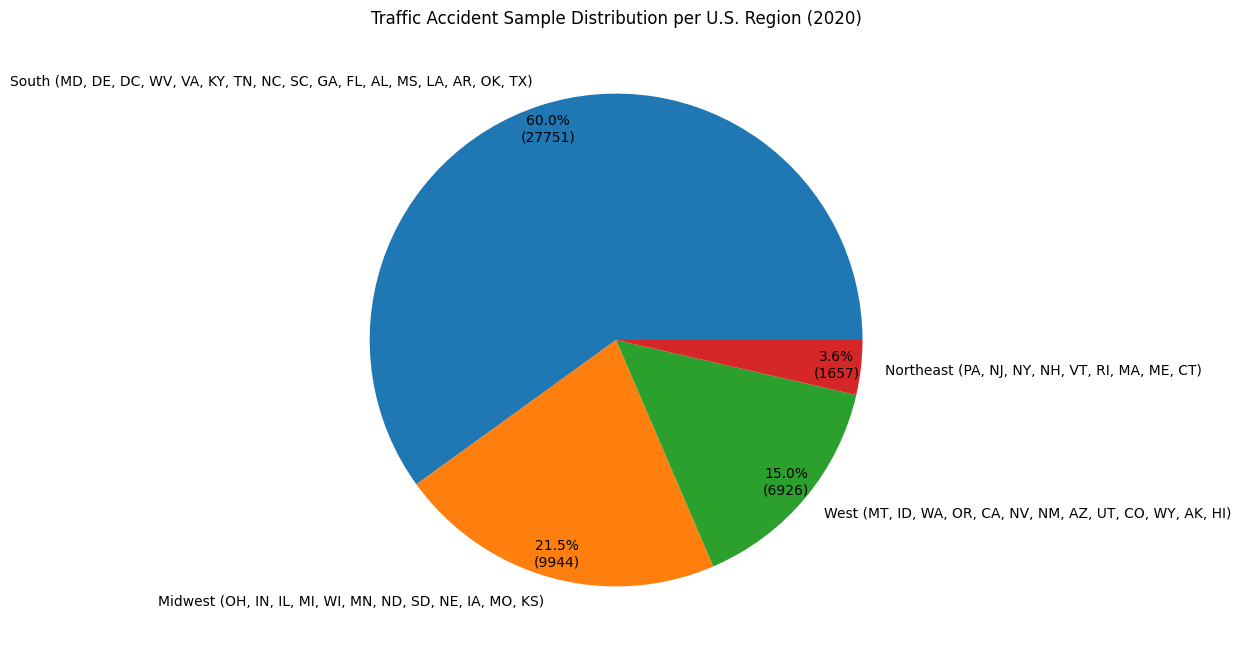

In [21]:

def func(pct):
    absolute = int(pct/100.*crssDf["accident"]["REGION"].count())
    return "{:.1f}%\n({:d})".format(pct, absolute)

#autopct = "%1.1f%%" if not using function

_ = accStatesDf.plot.pie(y="TotalAcc",figsize=(8,8),legend = False, title = "Traffic Accident Sample Distribution per U.S. Region (2020)", \
    ylabel = "", autopct=lambda pct: func(pct), pctdistance = 0.9, rotatelabels = False)



In [22]:
accStatesWghtDf = crssDf["accident"][["REGION","WEIGHT"]].groupby("REGION").sum().sort_values(by="WEIGHT",ascending=False)
accStatesWghtDf.columns = ["TotalAcc"]
accStatesWghtDf["REGION"] = accStatesWghtDf.index.values
accStatesWghtDf["REGION"] = accStatesWghtDf.apply(lambda row: crssCategories["REGION"][row["REGION"]],axis=1)
##accStatesDf.loc["Others"] = [crssDf["accident"]["REGION"].count() - accStatesDf["TotalAcc"].sum(),"Others"]
accStatesWghtDf.set_index("REGION",inplace=True)
totalWeightedAccidents = accStatesWghtDf["TotalAcc"].sum()
accStatesWghtDf

,TotalAcc
REGION,
"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",2.676009e+06
"Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)",1.012983e+06
"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",6.219944e+05
"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",1.799086e+05


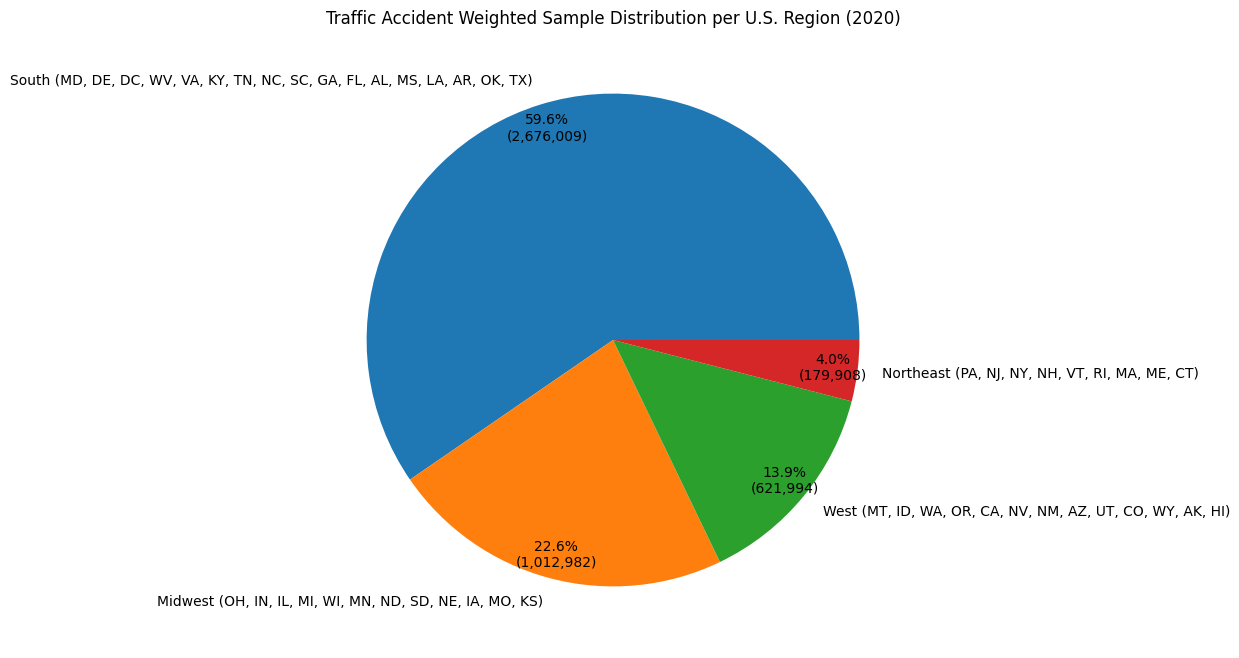

In [23]:

def func(pct):
    absolute = int(pct/100.*totalWeightedAccidents)
    return "{:.1f}%\n({:,})".format(pct, absolute)

#autopct = "%1.1f%%" if not using function

_ = accStatesWghtDf.plot.pie(y="TotalAcc",figsize=(8,8),legend = False, title = "Traffic Accident Weighted Sample Distribution per U.S. Region (2020)", \
    ylabel = "", autopct=lambda pct: func(pct), pctdistance = 0.9, rotatelabels = False)



In [24]:
#accTotalsDf = pd.DataFrame(dict(crssDf["accident"][["VE_TOTAL","VE_FORMS","PVH_INVL","PERSONS","PERMVIT","PERNOTMVIT","PEDS","FATALS"]].sum()),index = ["Total"])
accTotalsDf = pd.DataFrame(dict(crssDf["accident"][["VE_TOTAL","VE_FORMS","PVH_INVL","PERMVIT","PERNOTMVIT","PEDS","NUM_INJ"]].sum()),index = ["Total"])
accTotalsDf["Accidents"] = len(crssDf["accident"])
accTotalsDf["Occupants in Parked and Work Vehicles"] = accTotalsDf["PERNOTMVIT"] - accTotalsDf["PEDS"]
accTotalsDf = accTotalsDf.reindex(columns=['Accidents', 'VE_TOTAL', "VE_FORMS", 'PVH_INVL', 'PERMVIT', 'PERNOTMVIT', "Occupants in Parked and Work Vehicles",'PEDS','NUM_INJ'])
accTotalsDf.columns = ['Total Accidents', 'Total Vehicles', "Vehicles in Transport",'Parked and Working Vehicles', 'Occupants in Vehicles in Transport', 'Persons Not in Motor Vehicles in Transport', "Occupants in Parked and Work Vehicles", 'Person not in Vehicles','Number of Injuries']
accTotalsDf

,Total Accidents,Total Vehicles,Vehicles in Transport,Parked and Working Vehicles,Occupants in Vehicles in Transport,Persons Not in Motor Vehicles in Transport,Occupants in Parked and Work Vehicles,Person not in Vehicles,Number of Injuries
Total,46280,83690,81585,2105,109678,3243,308,2935,92698


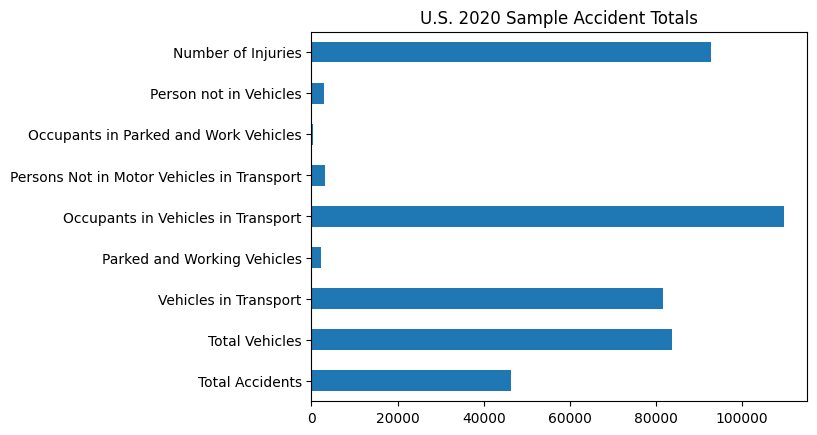

In [25]:
accTotalsSer = accTotalsDf.loc["Total"]
ax = accTotalsSer.plot.barh(title = "U.S. 2020 Sample Accident Totals")

In [26]:
crssMaxSevDf = pd.DataFrame(crssDf["accident"]["MAX_SEV"].value_counts().sort_values())
crssMaxSevDf.columns = ["TotalAccidents"]
crssMaxSevDf["MAX_SEV"] = crssMaxSevDf.index.values
crssMaxSevDf["MAX_SEV"] = crssMaxSevDf.apply(lambda row: crssCategories["MAX_SEV"][row["MAX_SEV"]],axis=1)
crssMaxSevDf.set_index("MAX_SEV",inplace=True)
crssMaxSevDf

,TotalAccidents
MAX_SEV,
Died Prior to Crash*,1
No person involved,19
"Injured, Severity Unknown",138
Unknown/Not Reported,554
Fatal Injury (K),1246
Suspected Serious Injury (A),5168
Suspected Minor Injury (B),8067
Possible Injury (C),9703
No Apparent Injury (O),21384


<AxesSubplot: title={'center': 'Sampled Accidents Injury Types'}>

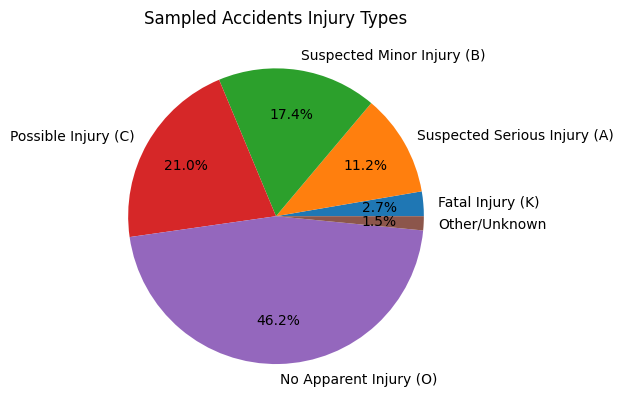

In [27]:
crssMaxSevDftmp = crssMaxSevDf[crssMaxSevDf["TotalAccidents"]/crssMaxSevDf["TotalAccidents"].sum() >= 0.02].copy()
crssMaxSevDftmp.loc["Other/Unknown"] = [crssMaxSevDf["TotalAccidents"].sum() - crssMaxSevDftmp["TotalAccidents"].sum()]
crssMaxSevDftmp["TotalAccidents"].plot.pie(legend = False, ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False, title = "Sampled Accidents Injury Types")

<AxesSubplot: title={'center': 'Vehicles in Transport vs Parked and Working Vehicles'}>

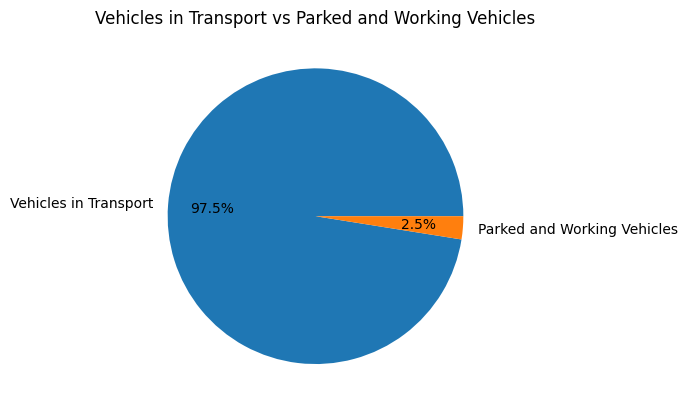

In [28]:
accTotalsDf.loc["Total"][["Vehicles in Transport",'Parked and Working Vehicles']].plot.pie(legend = False, title = "Vehicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

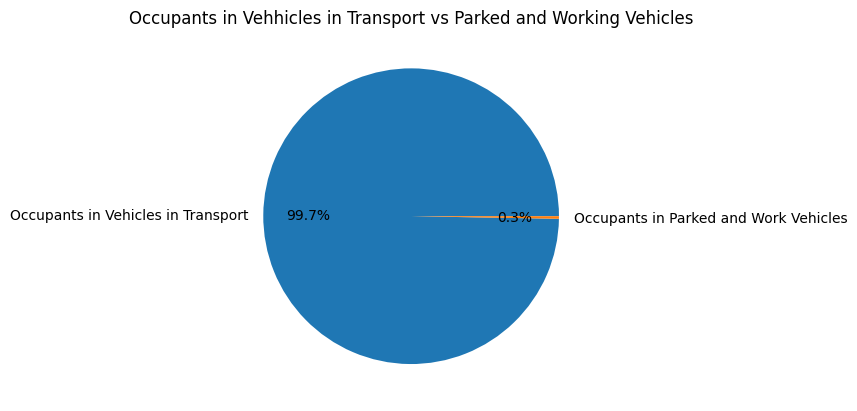

In [29]:
_ = accTotalsDf.loc["Total"][['Occupants in Vehicles in Transport',"Occupants in Parked and Work Vehicles"]].plot.pie(legend = False, title = "Occupants in Vehhicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [30]:
# accidents by month
accMonthDf = pd.DataFrame(crssDf["accident"]["MONTH"].value_counts()).sort_index()
accMonthDf.columns = ["TotalAcc"]
accMonthDf["MONTH"] = accMonthDf.index.values
accMonthDf["MONTH"] = accMonthDf.apply(lambda row: crssCategories["MONTH"][row["MONTH"]],axis=1)
#accMonthDf.loc["Others"] = [crssDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accMonthDf.set_index("MONTH",inplace=True)
accMonthDf

,TotalAcc
MONTH,
January,3504
February,3424
March,2721
April,1751
May,2745
June,3877
July,4421
August,4641
September,4691


<AxesSubplot: title={'center': 'U.S. 2020 Sampled Traffic Accident per Month'}, xlabel='MONTH', ylabel='Total Falta Accidents'>

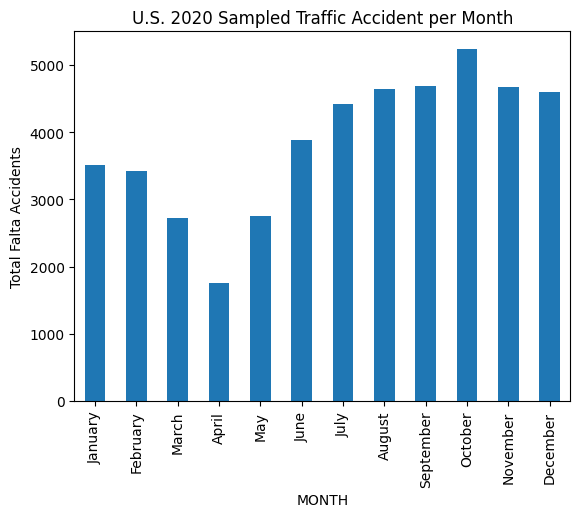

In [31]:
accMonthDf["TotalAcc"].plot.bar(title = "U.S. 2020 Sampled Traffic Accident per Month",legend = False, ylabel = "Total Falta Accidents")

In [32]:
# accidents by day of the week
accDayWeekDf = pd.DataFrame(crssDf["accident"]["DAY_WEEK"].value_counts()).sort_index()
accDayWeekDf.columns = ["TotalAcc"]
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.index.values
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.apply(lambda row: crssCategories["DAY_WEEK"][row["DAY_WEEK"]],axis=1)
#accMonthDf.loc["Others"] = [crssDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accDayWeekDf.set_index("DAY_WEEK",inplace=True)
accDayWeekDf

,TotalAcc
DAY_WEEK,
Sunday,5292
Monday,6323
Tuesday,6635
Wednesday,6941
Thursday,7012
Friday,7716
Saturday,6361


<AxesSubplot: title={'center': 'U.S. 2020 Sampled Traffic Accident per Day of the Week'}, xlabel='Day of the Week', ylabel='Total Falta Accidents'>

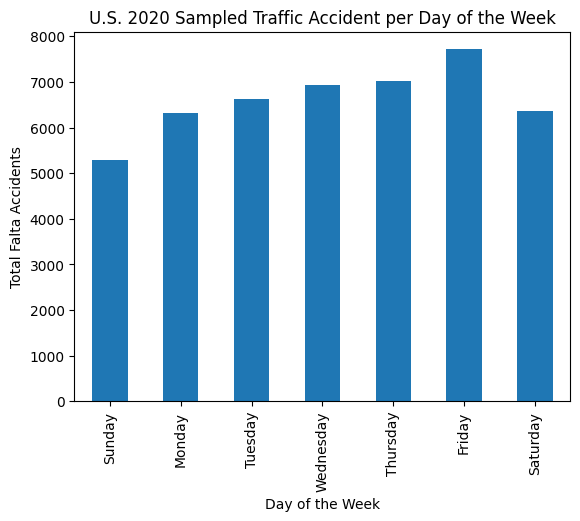

In [33]:
accDayWeekDf.plot.bar(title = "U.S. 2020 Sampled Traffic Accident per Day of the Week",legend = False, ylabel = "Total Falta Accidents", \
    xlabel = "Day of the Week")

In [34]:
# accidents and weather events
accWeatherDf = pd.DataFrame(crssDf["accident"]["WEATHER"].value_counts().sort_values(ascending=False))
accWeatherDf.columns = ["TotalAccidents"]
totalWeatherAcc = accWeatherDf["TotalAccidents"].sum()
accWeatherDf["WEATHER"] = accWeatherDf.index.values
accWeatherDf["WEATHER"] = accWeatherDf.apply(lambda row: crssCategories["WEATHER"][row["WEATHER"]],axis=1)
accWeatherDf.set_index("WEATHER",inplace=True)
# combined unknown and not reported rows
accWeatherDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
accWeatherDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accWeatherDf

,TotalAccidents
WEATHER,
Clear,32111
Cloudy,6085
Rain,4382
Snow,695
"Fog, Smog, Smoke",197
Severe Crosswinds,43
Blowing Snow,33
Sleet or Hail,29
Freezing Rain or Drizzle,17


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_9349/3199826246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]


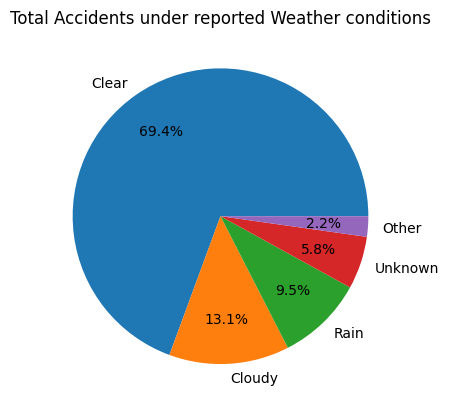

In [35]:
accWeatherDf = accWeatherDf[accWeatherDf["TotalAccidents"] > 2000]
accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]
_ = accWeatherDf["TotalAccidents"].plot.pie(legend = False, title = "Total Accidents under reported Weather conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [36]:
# accidents and light condition
accLightDf = pd.DataFrame(crssDf["accident"]["LGT_COND"].value_counts().sort_values(ascending=False))
accLightDf.columns = ["TotalAccidents"]
totalAcc = accLightDf["TotalAccidents"].sum()
accLightDf["LGT_COND"] = accLightDf.index.values
accLightDf["LGT_COND"] = accLightDf.apply(lambda row: crssCategories["LGT_COND"][row["LGT_COND"]],axis=1)
accLightDf.set_index("LGT_COND",inplace=True)
# combined unknown and not reported rows
#accLightDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
#accLightDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accLightDf

,TotalAccidents
LGT_COND,
Daylight,30813
Dark - Lighted,7432
Dark - Not Lighted,5358
Dusk,1189
Dawn,725
Not Reported,363
Dark - Unknown Lighting,333
Reported as Unknown,56
Other,11


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_9349/2442448774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]


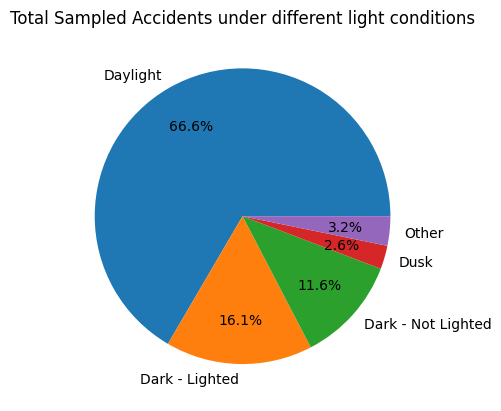

In [37]:
accLightDf = accLightDf[accLightDf["TotalAccidents"] > 900]
accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]
_ = accLightDf["TotalAccidents"].plot.pie(legend = False, title = "Total Sampled Accidents under different light conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [38]:
# accidents harmul events
accHarmEvDf = pd.DataFrame(crssDf["accident"]["HARM_EV_SIMP"].value_counts().sort_values(ascending=False))
accHarmEvDf.columns = ["TotalAccidents"]
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.index.values
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.apply(lambda row: crssCategories["HARM_EV_SIMP"][row["HARM_EV_SIMP"]],axis=1)
#accMonthDf.loc["Others"] = [crssDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accHarmEvDf.set_index("HARM_EV_SIMP",inplace=True)
totalAcc = accHarmEvDf["TotalAccidents"].sum()
accHarmEvDf

,TotalAccidents
HARM_EV_SIMP,
Motor Vehicle In-Transport,30793
Fixed object,6031
Animal,1728
Traffic Barrier,1486
Pedestrian,1461
Rollover/Overturn,1346
Parked Motor Vehicle,1276
Pedalcyclist,1103
Object not-fixed,458


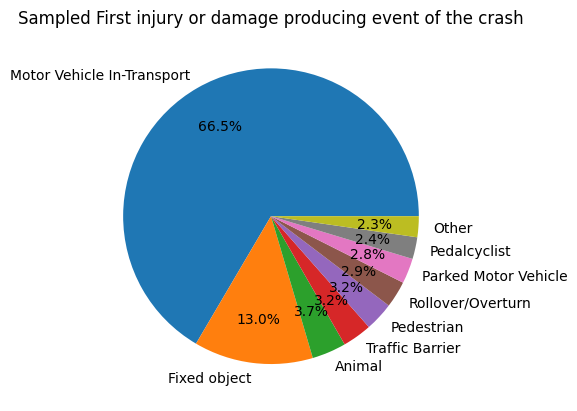

In [39]:
accHarmEvDf = accHarmEvDf[accHarmEvDf["TotalAccidents"] > 500].copy()
accHarmEvDf.loc["Other"] = [totalAcc - accHarmEvDf["TotalAccidents"].sum()]
_ = accHarmEvDf["TotalAccidents"].plot.pie(legend = False, title = "Sampled First injury or damage producing event of the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [40]:
# for Events including Motort Vehicle in Transport orientation of montor vehicles
accManCollDf = pd.DataFrame(crssDf["accident"]["MAN_COLL"].value_counts().sort_values(ascending=False))
accManCollDf.columns = ["TotalAccidents"]
accManCollDf["MAN_COLL"] = accManCollDf.index.values
accManCollDf["MAN_COLL"] = accManCollDf.apply(lambda row: crssCategories["MAN_COLL"][row["MAN_COLL"]],axis=1)
#accMonthDf.loc["Others"] = [crssDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accManCollDf.set_index("MAN_COLL",inplace=True)
accManCollDf

,TotalAccidents
MAN_COLL,
The First Harmful Event was Not a Collision with a Motor Vehicle In Transport,15481
Front-to-Rear,12201
Angle,11915
Sideswipe - Same Direction,4049
Front-to-Front,1368
Sideswipe - Opposite Direction,667
Rear-to-Side,326
Other,188
Not Reported,40


In [41]:
accManCollDf.drop(index=["The First Harmful Event was Not a Collision with a Motor Vehicle In Transport"],inplace=True)
totMVinTransportAcc = accManCollDf["TotalAccidents"].sum()
accManCollDf

,TotalAccidents
MAN_COLL,
Front-to-Rear,12201
Angle,11915
Sideswipe - Same Direction,4049
Front-to-Front,1368
Sideswipe - Opposite Direction,667
Rear-to-Side,326
Other,188
Not Reported,40
Reported as Unknown,29


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_9349/3567835035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]


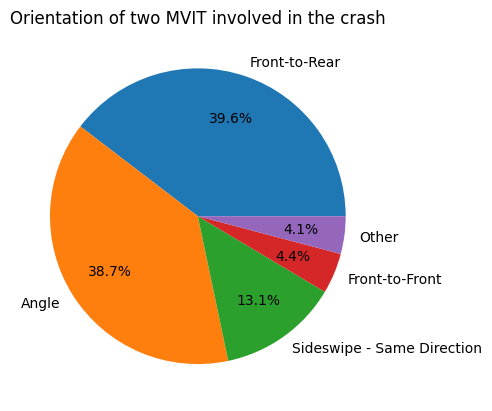

In [42]:
# keep evetns that make at least 3% of total
accManCollDf = accManCollDf[accManCollDf["TotalAccidents"]/totMVinTransportAcc >= 0.03]
accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]
_ = accManCollDf["TotalAccidents"].plot.pie(legend = False, title = "Orientation of two MVIT involved in the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [43]:
# Vehicle Make 
# accidents harmul events
vehModDf = pd.DataFrame(crssDf["vehicle"]["MAKE"].value_counts().sort_values(ascending=False)).head(20)
vehModDf.columns = ["TotalVehicles"]
vehModDf["MAKE"] = vehModDf.index.values
vehModDf["MAKE"] = vehModDf.apply(lambda row: crssCategories["MAKE"][row["MAKE"]],axis=1)
vehModDf.set_index("MAKE",inplace=True)
totalVeh = len(crssDf["vehicle"])
vehModDf.loc["Others"] = [totalVeh - vehModDf["TotalVehicles"].sum()]
vehModDf


,TotalVehicles
MAKE,
Ford,10537
Chevrolet,10129
Toyota,8707
Honda,6949
Nissan/Datsun,6314
Dodge,4665
Hyundai,3274
KIA,2734
Jeep / Kaiser-Jeep / Willys- Jeep,2614


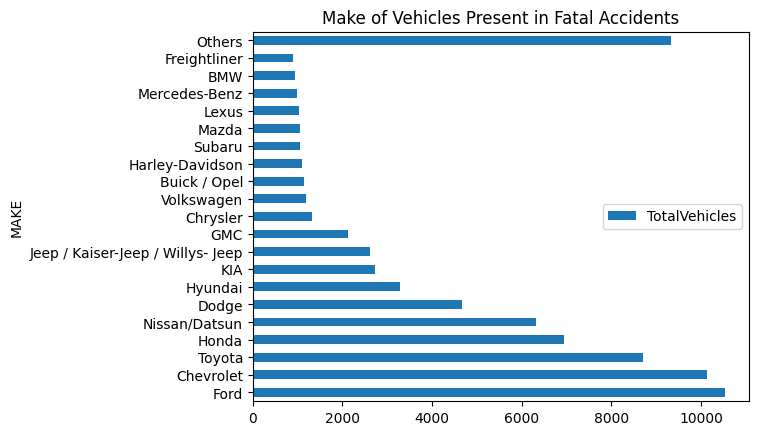

In [44]:
#accTotalsSer = vehModDf.loc["TotalVehicles"]
ax = vehModDf.plot.barh(title = "Make of Vehicles Present in Fatal Accidents")

In [45]:
# Vehicle Model Year
vehYrDf = pd.DataFrame(crssDf["vehicle"]["MOD_YEAR"].value_counts())
vehYrDf.columns = ["TotalVehicles"]
vehYrDf["MOD_YEAR"] = vehYrDf.index.values
#vehYrDf["MAKE"] = vehYrDf.apply(lambda row: crssCategories["MAKE"][row["MAKE"]],axis=1)
#vehYrDf.set_index("MOD_YEAR",inplace=True)
totalVeh = len(crssDf["vehicle"])
#vehYrDf.loc["Others"] = [totalVeh - vehYrDf["TotalVehicles"].sum()]
#vehYrDf.loc["Unknown"] = [vehYrDf.loc[9998]["TotalVehicles"] + vehYrDf.loc[9999]["TotalVehicles"],np.NaN]
#vehYrDf.drop(index=[9998,9999],inplace=True)
vehYrDf

,TotalVehicles,MOD_YEAR
2016,6387,2016
2017,6318,2017
2019,5948,2019
2018,5510,2018
2015,4484,2015
2014,4011,2014
2013,3785,2013
2020,3636,2020
2007,3523,2007
2012,3419,2012


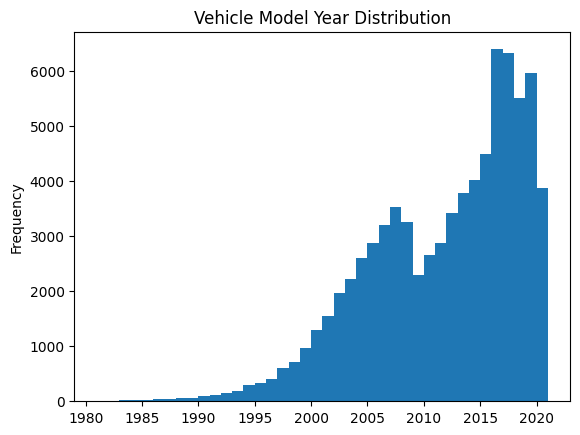

In [46]:
_ = crssDf["vehicle"][crssDf["vehicle"]["MOD_YEAR"] < 9998]["MOD_YEAR"].plot.hist(bins=40,title="Vehicle Model Year Distribution")

Text(0.5, 1.0, 'Vehicle Model Year')

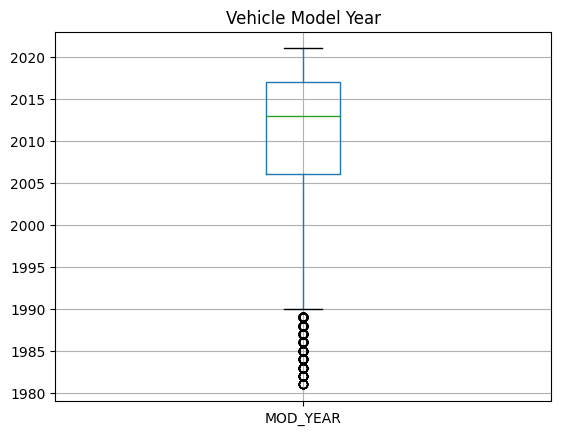

In [47]:
#ax = vehYrDf.boxplot(column="MOD_YEAR")
ax = crssDf["vehicle"][crssDf["vehicle"]["MOD_YEAR"] < 9998].boxplot(column="MOD_YEAR")
ax.set_title("Vehicle Model Year")

In [48]:
# Vehicle Body class
vehBodyDf = pd.DataFrame(crssDf["vehicle"]["VPICBODYCLASS"].value_counts())
vehBodyDf.columns = ["TotalVehicles"]
vehBodyDf["VPICBODYCLASS"] = vehBodyDf.index.values
vehBodyDf["VPICBODYCLASS"] = vehBodyDf.apply(lambda row: crssCategories["VPICBODYCLASS"][row["VPICBODYCLASS"]],axis=1)
vehBodyDf.set_index("VPICBODYCLASS",inplace=True)
vehBodyDf

,TotalVehicles
VPICBODYCLASS,
Sedan/Saloon,28846
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV),20714
Pickup,11013
Hatchback/Liftback/Notchback,2652
Coupe,2466
Minivan,2065
Truck-Tractor,1691
Crossover Utility Vehicle (CUV),1076
Cargo Van,935


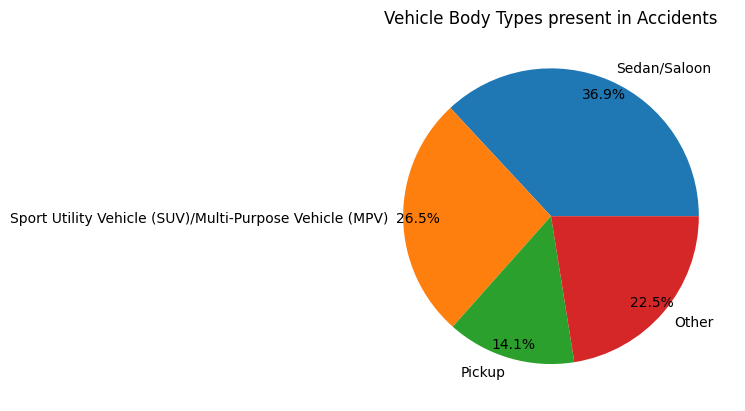

In [49]:
# keep evetns that make at least 3% of total
vehBodyDf = vehBodyDf[vehBodyDf["TotalVehicles"]/totalVeh >= 0.034].copy()
vehBodyDf.loc["Other"] = totalVeh - vehBodyDf["TotalVehicles"].sum()
_ = vehBodyDf["TotalVehicles"].plot.pie(legend = False, title = "Vehicle Body Types present in Accidents", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.9, rotatelabels = False)

In [50]:
# Driver was Drinking
vehDrinkDf = pd.DataFrame(crssDf["vehicle"]["VEH_ALCH"].value_counts().sort_values(ascending=False))
vehDrinkDf.columns = ["TotalVehicles"]
vehDrinkDf["VEH_ALCH"] = vehDrinkDf.index.values
vehDrinkDf["VEH_ALCH"] = vehDrinkDf.apply(lambda row: crssCategories["VEH_ALCH"][row["VEH_ALCH"]],axis=1)
vehDrinkDf.set_index("VEH_ALCH",inplace=True)
totalVeh = len(crssDf["vehicle"])
#vehDrinkDf.loc["Others"] = [totalVeh - vehDrinkDf["TotalVehicles"].sum()]
vehDrinkDf

,TotalVehicles
VEH_ALCH,
No Alcohol Involved,54090
Reported as Unknown,21428
Alcohol Involved,2450
No Driver Present,169


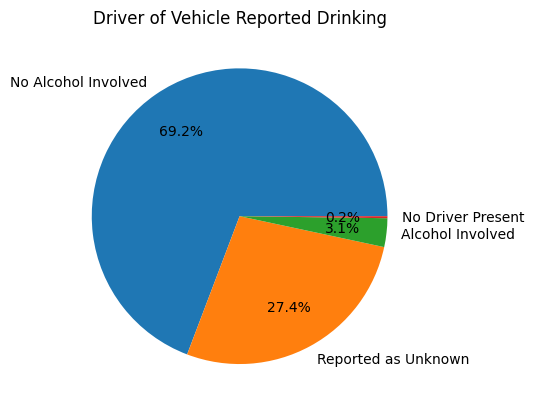

In [51]:
_ = vehDrinkDf["TotalVehicles"].plot.pie(legend = False, title = "Driver of Vehicle Reported Drinking", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [52]:
# simplify access to driver information from "person" table
driversDf = crssDf["person"][crssDf["person"]["PER_TYP"] == 1]
totalDrivers = len(driversDf)

In [53]:
# Driver's Sex
drSexDf = pd.DataFrame(driversDf["SEX"].value_counts().sort_values(ascending=False))
drSexDf.columns = ["TotalDrivers"]
drSexDf["SEX"] = drSexDf.index.values
drSexDf["SEX"] = drSexDf.apply(lambda row: crssCategories["SEX"][row["SEX"]],axis=1)
drSexDf.set_index("SEX",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drSexDf.loc["Unknown"] = drSexDf.loc["Reported as Unknown"] + drSexDf.loc["Not Reported"]
drSexDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
drSexDf

,TotalDrivers
SEX,
Male,53996
Female,35950
Unknown,4554


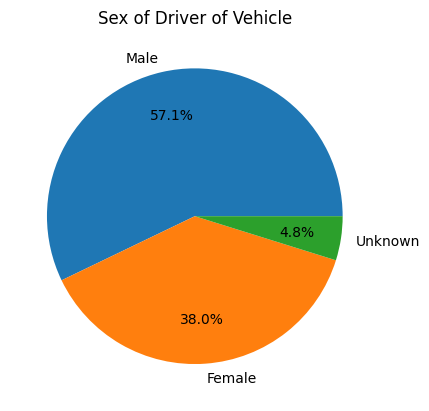

In [54]:
_ = drSexDf["TotalDrivers"].plot.pie(legend = False, title = "Sex of Driver of Vehicle", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [55]:
# Driver's Age
drAgeDf = pd.DataFrame(driversDf["AGE"].value_counts().sort_index())
drAgeDf.columns = ["TotalDrivers"]
drAgeDf["AGE"] = drAgeDf.index.values
#drAgeDf["SEX"] = drAgeDf.apply(lambda row: crssCategories["SEX"][row["SEX"]],axis=1)
#drAgeDf.set_index("AGE",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drAgeDf.loc["Unknown"] = [drAgeDf.loc[998]["TotalDrivers"] + drAgeDf.loc[999]["TotalDrivers"],np.NaN]
drAgeDf.drop(index=[998,999],inplace=True)
drAgeDf

,TotalDrivers,AGE
7,1.0,7.0
8,1.0,8.0
10,3.0,10.0
11,7.0,11.0
12,5.0,12.0
...,...,...
100,1.0,100.0
101,1.0,101.0
119,1.0,119.0
120,1.0,120.0


In [56]:
drAgeDf["AGE"].describe()

count     96.000000
mean      55.833333
std       28.593951
min        7.000000
25%       31.750000
50%       55.500000
75%       79.250000
max      120.000000
Name: AGE, dtype: float64

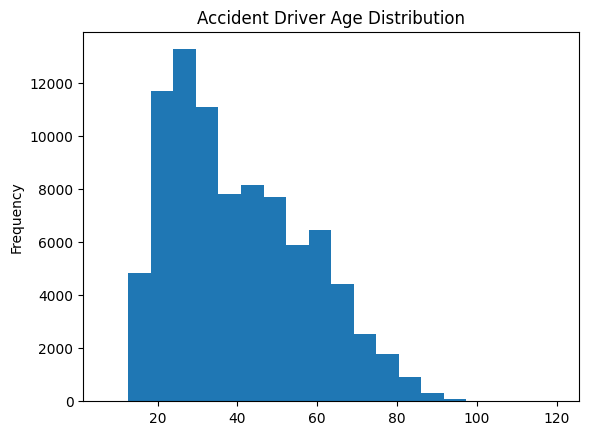

In [57]:
#_ = drAgeDf.drop(index="Unknown").plot.hist(by="TotalDrivers")
_ = driversDf[driversDf["AGE"] < 998]["AGE"].plot.hist(bins=20,title="Accident Driver Age Distribution")

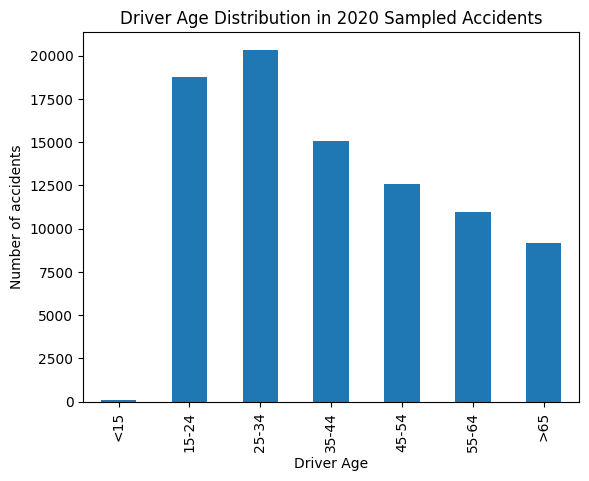

In [58]:
driverAgeCut = pd.cut(driversDf[driversDf["AGE"] < 998]["AGE"],[0,14,24,34,44,54,64,200],labels=["<15","15-24","25-34","35-44","45-54","55-64",">65"])
#_ = driverAgeCut.plot.scatter(title="Accident Driver Age Distribution")
#driverAgeCut.value_counts().plot.bar()
ax = driverAgeCut.value_counts(sort=False).plot.bar(title="Driver Age Distribution in 2020 Sampled Accidents",xlabel="Driver Age",ylabel="Number of accidents")

Text(0.5, 0.98, '')

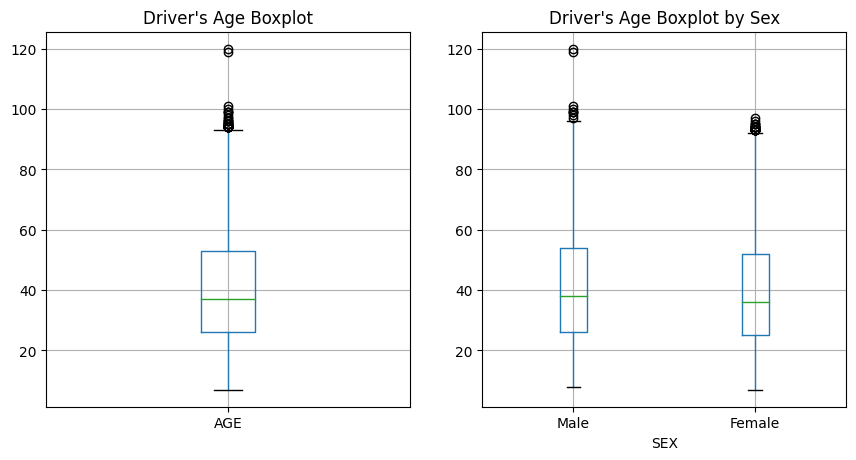

In [59]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
driversDf[driversDf["AGE"] < 998].boxplot(column="AGE",ax=ax1)
ax1.set_title("Driver's Age Boxplot")
driversDf[(driversDf["AGE"] < 998) & (driversDf["SEX"].isin([1,2]))].boxplot(column="AGE",by="SEX",ax=ax2)
ax2.set_title("Driver's Age Boxplot by Sex")
a = ax2.get_xticklabels()
ax2.set_xticklabels([crssCategories["SEX"][int(a[0].get_text())],crssCategories["SEX"][int(a[1].get_text())]])
fig.suptitle("")


## Safety features

In [60]:
safetyFeaturesColumns = [
 	"ForwardCollisionWarningId",
	"DynamicBrakeSupportId",
	"CrashImminentBrakingID",
	"PedestrianAutoEmergencyBrakingId",
	"BlindSpotWarningId",
	"BlindSpotInterventionId",
	"LaneDepartureWarningId",
	"LaneKeepingAssistanceId",
	"LaneCenteringAssistanceId",
	"BackupCameraId",
	"RearCrossTrafficAlertId",
	"RearAutomaticEmergencyBrakingId",
	"ParkAssistId",
	"DaytimeRunningLightId",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId",
	"AdaptiveDrivingBeamId",
	"AdaptiveCruiseControlId",
	"AntilockBrakeSystemId",
	"ElectronicStabilityControlId",
	"TPMSId",
	"TractionControlId",
	"AutoPedestrianAlertingSoundId",
]

safetyFeaturesNames = {
 	"ForwardCollisionWarningId" : "Forward Collision Warning",
	"DynamicBrakeSupportId" : "Dynamic Brake Support",
	"CrashImminentBrakingID" : "Crash Imminent Braking",
	"PedestrianAutoEmergencyBrakingId" : "Pedestrian Auto Emergency Braking",
	"BlindSpotWarningId" : "Blind Spot Warning",
	"BlindSpotInterventionId": "Blind Spot Intervention",
	"LaneDepartureWarningId" : "Lane Departure Warning",
	"LaneKeepingAssistanceId" : "Lane Keeping Assistance",
	"LaneCenteringAssistanceId" : "Lane Centering Assistance",
	"BackupCameraId" : "Backup Camera",
	"RearCrossTrafficAlertId" : "Rear Cross Traffic Alert",
	"RearAutomaticEmergencyBrakingId" : "Rear Automatic Emergency Braking",
	"ParkAssistId" : "Park Assist",
	"DaytimeRunningLightId" : "Daytime Running Light",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId" : "Semi Auto Headlamp Beam Switching",
	"AdaptiveDrivingBeamId" : "Adaptive Driving Beam",
	"AdaptiveCruiseControlId" : "Adaptive Cruise Control",
	"AntilockBrakeSystemId" : "Antilock Brake System",
	"ElectronicStabilityControlId" : "Electronic Stability Control",
	"TPMSId" : "Tire Pressure Monitoring System",
	"TractionControlId" : "Traction Control",
	"AutoPedestrianAlertingSoundId" : "Auto Pedestrian Alerting Sound",
}


def AnyStdSafetyFeature(vpicRow):
	"""Returns true if any of the safety features are marked standard for the vehicle checked 
	(vpicdecode columnnames are used)attribute value = 1 means standard
	"""
	
	stdFeatureFlag = False
	for feat in safetyFeaturesColumns:
		stdFeatureFlag = stdFeatureFlag | (vpicRow[feat] == 1)
	return stdFeatureFlag

def GoodVPICDecode(picDecodeResult):
	return (picDecodeResult in {'0','0,10','1,10','1,400','1,10,400'})


In [61]:
crssDf["vpicdecode"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80526 entries, 0 to 80525
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CASENUM                           80526 non-null  int64  
 1   VEH_NO                            80526 non-null  int64  
 2   VehicleDescriptor                 80442 non-null  object 
 3   VINDecodeError                    80526 non-null  object 
 4   VehicleTypeId                     80526 non-null  int64  
 5   ManufacturerFullNameId            80526 non-null  int64  
 6   MakeId                            80526 non-null  int64  
 7   ModelId                           80526 non-null  int64  
 8   ModelYear                         80526 non-null  int64  
 9   Series                            53326 non-null  object 
 10  Trim                              28717 non-null  object 
 11  Series2                           14313 non-null  object 
 12  Trim

In [62]:
crssDf["vpicdecode"].describe(include="all")

,CASENUM,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,DaytimeRunningLightId,HeadlampLightSourceId,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId
count,8.052600e+04,80526.000000,80442,80526,80526.000000,80526.000000,80526.000000,80526.000000,80526.000000,53326,...,16263.000000,3977.000000,16553.000000,8433.000000,9129.000000,17696.000000,15458.0,46022.000000,14755.000000,4109.000000
unique,NaN,NaN,25676,6,NaN,NaN,NaN,NaN,NaN,2513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3N1AB7AP*KY******,0,NaN,NaN,NaN,NaN,NaN,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,166,70927,NaN,NaN,NaN,NaN,NaN,2111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.020026e+11,1.524812,NaN,NaN,3.871532,1237.165450,547.322902,3528.637968,2011.228386,NaN,...,0.837914,0.440785,0.839727,1.056564,1.147223,1.000452,1.0,1.085372,1.000271,0.288391
std,2.175823e+05,0.667086,NaN,NaN,2.435972,1566.889352,515.494794,3972.981400,6.710754,NaN,...,0.489638,1.014024,0.485022,1.119519,1.148587,0.028124,0.0,0.279826,0.023284,0.598045
min,2.020021e+11,1.000000,NaN,NaN,1.000000,955.000000,440.000000,1684.000000,1981.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000
25%,2.020025e+11,1.000000,NaN,NaN,2.000000,984.000000,460.000000,1852.000000,2006.000000,NaN,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
50%,2.020026e+11,1.000000,NaN,NaN,3.000000,994.000000,474.000000,1947.000000,2013.000000,NaN,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000
75%,2.020028e+11,2.000000,NaN,NaN,7.000000,1034.000000,481.000000,2692.750000,2017.000000,NaN,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.0,1.000000,1.000000,0.000000


In [63]:
crssDf["vpicdecode"]["VINDecodeError"].value_counts()

0        70927
1         9504
0,10        61
1,400       25
1,10         8
400          1
Name: VINDecodeError, dtype: int64

In [64]:
badVPICcount = len(crssDf["vpicdecode"]) - (crssDf["vpicdecode"]["VINDecodeError"] == '0').sum()
print("Bad VIN Decodes = ",badVPICcount, "(", badVPICcount/len(crssDf["vpicdecode"])*100,"%)")

Bad VIN Decodes =  9599 ( 11.92037354394854 %)


In [65]:
crssDf["vpicdecode"]["AnySafetyFeature"] = crssDf["vpicdecode"].apply(lambda row: AnyStdSafetyFeature(row),axis=1)
#crssDf["vpicdecode"]["GoodVPICDecode"] = crssDf["vpicdecode"].apply(lambda row: (row["VINDecodeError"] == '0'),axis=1)
crssDf["vpicdecode"]["GoodVPICDecode"] = crssDf["vpicdecode"].apply(lambda row: (GoodVPICDecode(row["VINDecodeError"])),axis=1)


In [66]:
print(crssDf["vpicdecode"]["GoodVPICDecode"].sum())
print(crssDf["vpicdecode"]["AnySafetyFeature"].sum())
badVPICcount = len(crssDf["vpicdecode"]) - crssDf["vpicdecode"]["GoodVPICDecode"].sum()
print("Bad VIN Decodes = ",badVPICcount, "(", badVPICcount/len(crssDf["vpicdecode"])*100,"%)")

71021
45709
Bad VIN Decodes =  9505 ( 11.803641060030301 %)


In [67]:
badVINrecords = crssDf["vpicdecode"][crssDf["vpicdecode"]["GoodVPICDecode"]==False]
badVINrecords

,CASENUM,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId,AnySafetyFeature,GoodVPICDecode
265,202002136343,1,JN1CA31D*YT******,1,2,996,478,2302,2000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
394,202002140153,1,1J8GR48K*7C******,1,7,994,483,1949,2007,WK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
898,202002153571,1,5N1AN0NM*DN******,1,7,997,478,1916,2013,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,True,False
1791,202002183179,2,1Fuba6cg*6D******,1,3,1024,450,2482,2006,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1898,202002188740,1,2HGFG126*6H******,1,2,990,474,1863,2006,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80264,202002997207,2,1FTPW145*4K******,1,3,976,460,1801,2004,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
80266,202002997447,1,3AKJHHDR*LS******,1,3,1024,450,13805,2020,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
80287,202002997638,1,ZACCJABB*HP******,1,7,1029,483,6160,2017,NaN,...,1.0,3.0,NaN,1.0,1.0,1.0,1.0,NaN,True,False
80339,202003000452,2,JN8AS58T*9W******,1,7,996,478,1913,2009,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,True,False


In [68]:
print("Vehicles in vehicle table vs vpicdecode tables")
print("VPIC entries =",len(crssDf["vpicdecode"]),"Vehicle Entries =",len(crssDf["vehicle"]),"Vehicle Entires with Unkown Year =",(crssDf["vehicle"]["MOD_YEAR"] >= 9998).sum())

Vehicles in vehicle table vs vpicdecode tables
VPIC entries = 80526 Vehicle Entries = 78137 Vehicle Entires with Unkown Year = 0


In [69]:
# Vehicle Safety Features vs Model Year
# join vehicle table with vpictable 
#vehSafetyYrDf = pd.merge(crssDf["vehicle"][crssDf["vehicle"]["MOD_YEAR"] < 9998],crssDf["vpicdecode"], on = ["CASENUM","VEH_NO"])
vehVpicMergeDf = pd.merge(crssDf["vehicle"],crssDf["vpicdecode"], on = ["CASENUM","VEH_NO"])
vehSafetyYrDf = vehVpicMergeDf[["MOD_YEAR","AnySafetyFeature"]].groupby("MOD_YEAR").agg(['count','sum'])
vehSafetyYrDf = vehSafetyYrDf["AnySafetyFeature"]
vehSafetyYrDf.columns = ["Total Cars","Cars with Safey Features"]
#vehSafetyYrDf = pd.DataFrame(crssDf["vpicdecode"][["ModelYear","AnySafetyFeature"]].value_counts())
#vehSafetyYrDf.columns = ["TotalVehicles"]
#vehSafetyYrDf["VPICBODYCLASS"] = vehSafetyYrDf.index.values
#vehSafetyYrDf["VPICBODYCLASS"] = vehSafetyYrDf.apply(lambda row: crssCategories["VPICBODYCLASS"][row["VPICBODYCLASS"]],axis=1)
#vehSafetyYrDf.set_index("VPICBODYCLASS",inplace=True)
#vehSafetyYrDf["STATE"] = accStatesDf.apply(lambda row: crssCategories["STATE"][row["STATE"]],axis=1)
vehSafetyYrDf.info(verbose=True,show_counts=True)
#        ["MAKE","MAKENAME"],
#        ["MAK_MOD","MAK_MODNAME"],
##tempDf = vehSafetyYrDf[vehSafetyYrDf["MOD_YEAR"] != vehSafetyYrDf["ModelYear"]][["MOD_YEAR","ModelYear","MAKE","MAK_MOD","MakeId","ModelId"]].copy()
##temp2Df = vehSafetyYrDf[vehSafetyYrDf["MOD_YEAR"] == vehSafetyYrDf["ModelYear"]][["MOD_YEAR","ModelYear","MAKE","MAK_MOD","MakeId","ModelId"]].copy()
##makeMappingVehVpicDf = vehSafetyYrDf[["MAKE","MakeId"]].drop_duplicates().dropna()
##modelMappingVehVpicDf = vehSafetyYrDf[["MAKE","MAK_MOD","MakeId","ModelId"]].drop_duplicates().dropna()

##makeMappingVehVpicDf["MakeVpic"] = makeMappingVehVpicDf.apply(lambda row: crssCategories["MakeId"][row["MakeId"]],axis=1)
##makeMappingVehVpicDf["MAKENAME"] = makeMappingVehVpicDf.apply(lambda row: crssCategories["MAKE"][row["MAKE"]],axis=1)

##modelMappingVehVpicDf["MakeVpic"] = modelMappingVehVpicDf.apply(lambda row: crssCategories["MakeId"][row["MakeId"]],axis=1)
##modelMappingVehVpicDf["MAKENAME"] = modelMappingVehVpicDf.apply(lambda row: crssCategories["MAKE"][row["MAKE"]],axis=1)
##modelMappingVehVpicDf["ModelVpic"] = modelMappingVehVpicDf.apply(lambda row: crssCategories["ModelId"][row["ModelId"]],axis=1)
##modelMappingVehVpicDf["MAK_MODNAME"] = modelMappingVehVpicDf.apply(lambda row: crssCategories["MAK_MOD"][row["MAK_MOD"]],axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 1981 to 2021
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Cars                41 non-null     int64
 1   Cars with Safey Features  41 non-null     int64
dtypes: int64(2)
memory usage: 984.0 bytes


In [70]:
vehSafetyFeatDf = vehVpicMergeDf[["AnySafetyFeature"]].value_counts().rename({True:"Yes", False:"No"})
vehSafetyFeatDf

AnySafetyFeature
Yes                 44542
No                  33595
dtype: int64

In [71]:
print(vehVpicMergeDf["MOD_YEAR"].drop_duplicates().sort_values().values)
print(crssDf["vehicle"]["MOD_YEAR"].drop_duplicates().sort_values().values)
print(crssDf["vpicdecode"]["ModelYear"].drop_duplicates().sort_values().values)

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


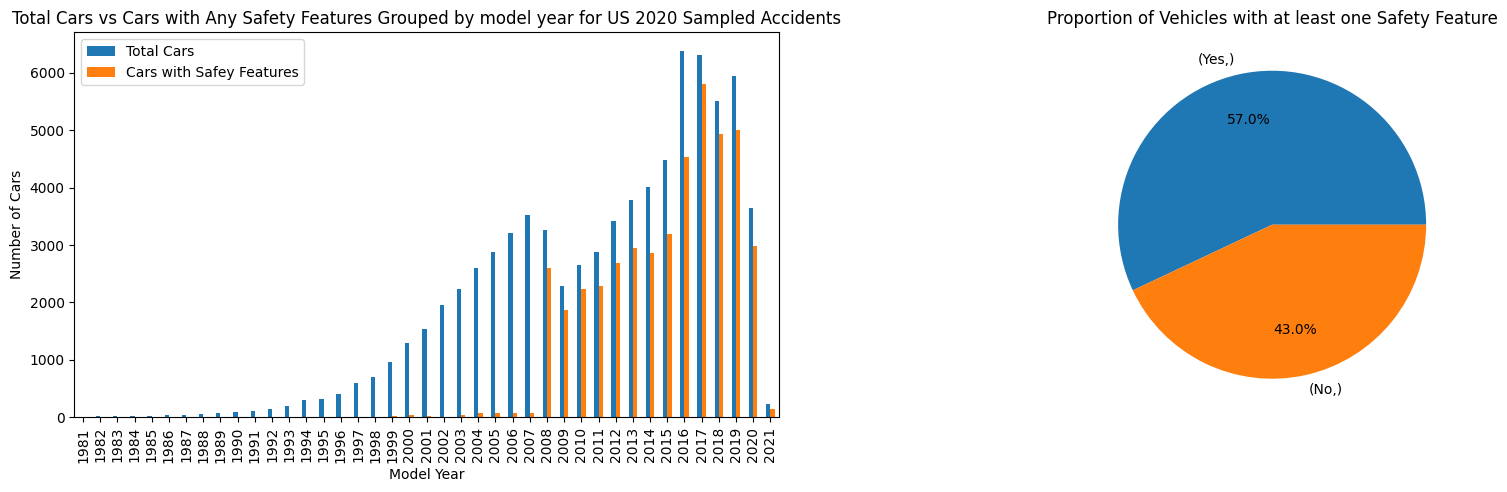

In [72]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
vehSafetyYrDf.plot.bar(stacked=False,ax=ax1)
ax1.set_xlabel("Model Year")
ax1.set_ylabel("Number of Cars")
ax1.set_title("Total Cars vs Cars with Any Safety Features Grouped by model year for US 2020 Sampled Accidents")
vehVpicMergeDf[["AnySafetyFeature"]].value_counts().rename({True:"Yes", False:"No"}).plot.pie(legend = False, \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False, ax=ax2)
_ = ax2.set_title("Proportion of Vehicles with at least one Safety Feature")

In [73]:
tempDf = vehVpicMergeDf[safetyFeaturesColumns].fillna(int(0))
vehSafetyFeaturesCnt = pd.Series(dtype='float64')
print("check values for every safety feature")
for x in tempDf.columns.sort_values():
    vehSafetyFeaturesCnt[safetyFeaturesNames[x]] = (tempDf[x] == 1).sum()/totalVeh*100
    print(x.ljust(max([len(x) for x in tempDf.columns])+2),"\t",str(tempDf[x].drop_duplicates().sort_values().values).ljust(16),(tempDf[x] == 1).sum())
tempDf = None
vehSafetyFeaturesCnt.sort_values(inplace=True)
vehSafetyFeaturesCnt

check values for every safety feature
AdaptiveCruiseControlId            	 [0. 1. 2. 3.]    3443
AdaptiveDrivingBeamId              	 [0. 1. 2. 3.]    3236
AntilockBrakeSystemId              	 [0. 1. 2. 3.]    17317
AutoPedestrianAlertingSoundId      	 [0. 1. 2.]       547
BackupCameraId                     	 [0. 1. 2. 3.]    14409
BlindSpotInterventionId            	 [0.]             0
BlindSpotWarningId                 	 [0. 1. 2. 3.]    3505
CrashImminentBrakingID             	 [0.]             0
DaytimeRunningLightId              	 [0. 1. 2. 3.]    12407
DynamicBrakeSupportId              	 [0. 1. 2. 3.]    13786
ElectronicStabilityControlId       	 [0. 1.]          15137
ForwardCollisionWarningId          	 [0. 1. 2. 3.]    5104
LaneCenteringAssistanceId          	 [0. 1.]          19
LaneDepartureWarningId             	 [0. 1. 2. 3.]    4350
LaneKeepingAssistanceId            	 [0. 1. 4. 5.]    3932
ParkAssistId                       	 [0. 1. 2. 3.]    517
PedestrianAutoEmergency

Rear Automatic Emergency Braking      0.000000
Blind Spot Intervention               0.000000
Crash Imminent Braking                0.000000
Lane Centering Assistance             0.024316
Rear Cross Traffic Alert              0.436413
Park Assist                           0.661658
Auto Pedestrian Alerting Sound        0.700052
Pedestrian Auto Emergency Braking     3.799736
Adaptive Driving Beam                 4.141444
Adaptive Cruise Control               4.406363
Blind Spot Warning                    4.485711
Lane Keeping Assistance               5.032187
Lane Departure Warning                5.567145
Forward Collision Warning             6.532117
Daytime Running Light                15.878521
Semi Auto Headlamp Beam Switching    16.272701
Dynamic Brake Support                17.643370
Backup Camera                        18.440688
Traction Control                     18.486760
Electronic Stability Control         19.372384
Antilock Brake System                22.162356
Tire Pressure

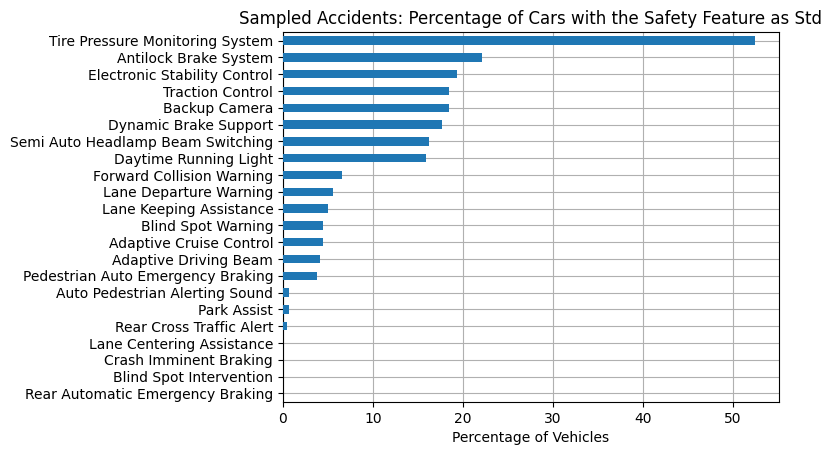

In [74]:
ax = vehSafetyFeaturesCnt.plot.barh(title="Sampled Accidents: Percentage of Cars with the Safety Feature as Std",zorder=3)
ax.set_xlabel("Percentage of Vehicles")
ax.grid()